# Recommendation Systems

<!--<badge>--><a href="https://colab.research.google.com/github/TheAIDojo/Machine_Learning_Bootcamp/blob/main/Week 09 - More Advanced DL Applications/2- Recommenders_Retrieval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><!--</badge>-->



Real-world recommender systems are often composed of two stages:

1. The retrieval stage is responsible for selecting an initial set of hundreds of candidates from all possible candidates. The main objective of this model is to efficiently weed out all candidates that the user is not interested in. Because the retrieval model may be dealing with millions of candidates, it has to be computationally efficient.
2. The ranking stage takes the outputs of the retrieval model and fine-tunes them to select the best possible handful of recommendations. Its task is to narrow down the set of items the user may be interested in to a shortlist of likely candidates.



Retrieval models are often composed of two sub-models:

1. A query model computing the query representation (normally a fixed-dimensionality embedding vector) using query features.
2. A candidate model computing the candidate representation (an equally-sized vector) using the candidate features

The outputs of the two models are then multiplied together to give a query-candidate affinity score, with higher scores expressing a better match between the candidate and the query.

In this tutorial, we're going to build and train such a two-tower model using the Movielens dataset.

We're going to:

1. Get our data and split it into a training and test set.
2. Implement a retrieval model.
3. Fit and evaluate it.




# TensorFlow Recommenders

{{badge}}

TensorFlow Recommenders (TFRS) is a library for building recommender system models.

It helps with the full workflow of building a recommender system: data preparation, model formulation, training, evaluation, and deployment.

It's built on Keras and aims to have a gentle learning curve while still giving you the flexibility to build complex models.

TFRS makes it possible to:
* Build and evaluate flexible recommendation retrieval models.
* Freely incorporate item, user, and context information into recommendation models.
* Train multi-task models that jointly optimize multiple recommendation objectives.
* TFRS is open source and available on Github.


In [ ]:
# install the tensorflow recommender library
!pip install -q tensorflow-recommenders

     |████████████████████████████████| 85 kB 2.4 MB/s 
     |████████████████████████████████| 462 kB 4.8 MB/s 


## Imports


Let's first get our imports out of the way.

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn import model_selection
import tensorflow_recommenders as tfrs

## The dataset

The Movielens dataset is a classic dataset from the [GroupLens](https://grouplens.org/datasets/movielens/) research group at the University of Minnesota. It contains a set of ratings given to movies by a set of users, and is a workhorse of recommender system research.

The data can be treated in two ways:

1. It can be interpreted as expressesing which movies the users watched (and rated), and which they did not. This is a form of implicit feedback, where users' watches tell us which things they prefer to see and which they'd rather not see.
2. It can also be seen as expressesing how much the users liked the movies they did watch. This is a form of explicit feedback: given that a user watched a movie, we can tell roughly how much they liked by looking at the rating they have given.

In this tutorial, we are focusing on a retrieval system: a model that predicts a set of movies from the catalogue that the user is likely to watch. Often, implicit data is more useful here, and so we are going to treat Movielens as an implicit system. This means that every movie a user watched is a positive example, and every movie they have not seen is an implicit negative example.

## Load the data

In [ ]:
ratings = pd.read_csv("/content/100k-ratings.csv")
movies = pd.read_csv("/content/100k-movies.csv")

The movies dataset returns a pandas dataframe with the following columns: movie_genre, movie_id, and movie_title.

In [ ]:
movies

,movie_genres,movie_id,movie_title
0,[4],b'1681',b'You So Crazy (1994)'
1,[4 7],b'1457',b'Love Is All There Is (1996)'
2,[1 3],b'500',b'Fly Away Home (1996)'
3,[0],b'838',b'In the Line of Duty 2 (1987)'
4,[7],b'1648',"b'Niagara, Niagara (1997)'"
...,...,...,...
1677,[4],b'1611',b'Intimate Relations (1996)'
1678,[16],b'1125',"b'Innocents, The (1961)'"
1679,[4],b'824',"b'Great White Hype, The (1996)'"
1680,[7],b'1354',b'Venice/Venice (1992)'


The ratings dataset returns a DataFrame of movie id, user id, the assigned rating, timestamp, movie information, and user information:

In [ ]:
ratings

,bucketized_user_age,movie_genres,movie_id,movie_title,raw_user_age,timestamp,user_gender,user_id,user_occupation_label,user_occupation_text,user_rating,user_zip_code
0,45.0,[7],b'357',"b""One Flew Over the Cuckoo's Nest (1975)""",46.0,879024327,True,b'138',4,b'doctor',4.0,b'53211'
1,25.0,[ 4 14],b'709',b'Strictly Ballroom (1992)',32.0,875654590,True,b'92',5,b'entertainment',2.0,b'80525'
2,18.0,[4],b'412',"b'Very Brady Sequel, A (1996)'",24.0,882075110,True,b'301',17,b'student',4.0,b'55439'
3,50.0,[5 7],b'56',b'Pulp Fiction (1994)',50.0,883326919,True,b'60',4,b'healthcare',4.0,b'06472'
4,50.0,[10 16],b'895',b'Scream 2 (1997)',55.0,891409199,True,b'197',18,b'technician',3.0,b'75094'
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,25.0,[ 0 1 15],b'228',b'Star Trek: The Wrath of Khan (1982)',30.0,888557237,True,b'774',17,b'student',4.0,b'80027'
99996,35.0,[13 16],b'333',"b'Game, The (1997)'",41.0,891012877,True,b'313',14,b'marketing',4.0,b'60035'
99997,18.0,[10],b'567',"b""Wes Craven's New Nightmare (1994)""",19.0,879795430,False,b'262',17,b'student',1.0,b'78264'
99998,35.0,[ 0 10 15 16],b'183',b'Alien (1979)',37.0,892839492,False,b'911',21,b'writer',4.0,b'53210'


# Prepare the Dataset

In [ ]:
# create function to get the unique values of a column with there index
def create_unique_to_id(data):
    unique_id = {}
    id_unique = {}
    for i, x in enumerate(set(data)):
        # make sure to add 1 to the index to avoid 0
        unique_id[x] = i + 1
        id_unique[i + 1] = x
    return unique_id, id_unique

In [ ]:
# get the movie id and id movie dictionary
movie_id, id_movie = create_unique_to_id(ratings.movie_title)
# convert the movie title column to numeric values
movies_ids = ratings.movie_title.replace(movie_id)
movies_ids

0        1248
1          92
2        1442
3         702
4        1414
         ... 
99995     674
99996    1647
99997    1517
99998     527
99999     435
Name: movie_title, Length: 100000, dtype: int64

In [ ]:
# get the user id and id user dictionary
user_id, id_user = create_unique_to_id(ratings.user_id)
# convert the user id column to numeric values
users_ids = ratings.user_id.replace(user_id)
users_ids

0        747
1        777
2        827
3        939
4        171
        ... 
99995    812
99996    808
99997    146
99998    577
99999    905
Name: user_id, Length: 100000, dtype: int64

In [ ]:
# convert the movie title column to numeric values
movies_candidates = movies.movie_title.replace(movie_id)
movies_candidates

0       1409
1        103
2        499
3         59
4        906
        ... 
1677    1567
1678     571
1679    1329
1680    1556
1681     554
Name: movie_title, Length: 1682, dtype: int64

# Create the Data Pipeline

In [ ]:
# create the function of data pipeline
def create_datapipelline(x1=None, x2=None, batch_size=64):
    # if we have two inputs
    if type(x2) != type(None):
        data = tf.data.Dataset.from_tensor_slices(((x1, x2)))
        data = data.shuffle(10000)
        data = data.batch(batch_size)
    # if we have one input
    # note we don't need to shuffle the data for the candidate movies
    else:
        data = tf.data.Dataset.from_tensor_slices((x1))
        data = data.batch(batch_size)

    data = data.prefetch(tf.data.AUTOTUNE)
    # return the data pipeline
    return data


# create the data pipeline for the input data with the batch size of 8192
inputs_pipeline = create_datapipelline(users_ids, movies_ids, batch_size=8192)
# create the data pipeline for the candidate movies with the batch size of 128
movies_candidates_pipeline = create_datapipelline(movies_candidates, batch_size=128)

In [ ]:
# read the first batch of data from the inputs data pipeline
for x in inputs_pipeline.take(1):
    print(x)

(<tf.Tensor: shape=(8192,), dtype=int64, numpy=array([290, 641, 504, ..., 858, 750, 918])>, <tf.Tensor: shape=(8192,), dtype=int64, numpy=array([   7,  227,  563, ..., 1578,  818, 1525])>)


In [ ]:
# read the first batch of data from the candidate movies data pipeline
for x in movies_candidates_pipeline.take(1):
    print(x)

tf.Tensor(
[1409  103  499   59  906 1320  167 1391   47 1440 1260 1083  611  923
  426  140  396  628  294 1337  897 1087 1045  958  467   15  466 1425
   49  676  845 1461 1015  391 1349  448   74  820 1516  415 1277  491
  276   45  739  727 1540 1047  603  941  291  916  393  585 1275 1400
 1152  194  702 1100  627  881    8  121 1505 1266 1044  758 1271  275
  784  507 1127 1106  618 1486  268 1586  369  452  370 1037 1368  764
  791  106 1249  875  846  474  264  505 1163  690 1343 1580  213  379
 1254  460  580  927 1094  726  684 1528    1 1426  385  425  814  350
 1239  513 1503  547  973 1003  476  126 1535  643 1121 1570  318 1022
 1394  481], shape=(128,), dtype=int64)


# Create the Model

Choosing the architecture of our model is a key part of modelling.

Because we are building a two-tower retrieval model, we can build each tower separately and then combine them in the final model.

## Retrieval Model 

A simple model like this corresponds exactly to a classic matrix factorization approach. While defining a subclass of tf.keras.Model for this simple model might be overkill, we can easily extend it to an arbitrarily complex model using standard Keras components, as long as we return an embedding_dimension-wide output at the end.

Note: higher values of embedding vector will correspond to models that may be more accurate, but will also be slower to fit and more prone to overfitting.


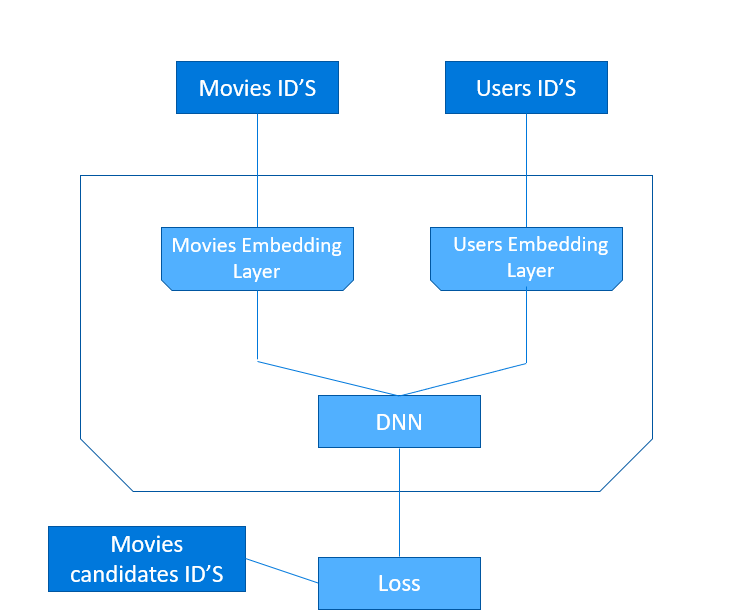

In [ ]:
# get the length of the user ids
users_unique_length = len(set(users_ids))
# create the user id model
# the model will contain one embedding layer with the size of the user id
class UserModel(tf.keras.Model):
    def __init__(self, users_unique_length, **kargs):
        super(UserModel, self).__init__(**kargs)
        # user embedding layer
        self.embedding = tf.keras.layers.Embedding(
            users_unique_length + 1, 64, input_length=1, mask_zero=True
        )

    def call(self, x):
        x = self.embedding(x)
        return x


# get the length of the movie ids
movies_unique_length = len(set(movies_ids))
# create the movie id model
# the model will contain one embedding layer with the size of the movie id
class MovieModel(tf.keras.Model):
    def __init__(self, movies_unique_length, **kargs):
        super(MovieModel, self).__init__(**kargs)
        # movie embedding layer
        self.embedding = tf.keras.layers.Embedding(
            movies_unique_length + 1, 64, input_length=1, mask_zero=True
        )

    def call(self, x):
        x = self.embedding(x)
        return x

In [ ]:
# create the user model & movie model
movie_model = MovieModel(movies_unique_length, name="Movies_Model")

user_model = UserModel(users_unique_length, name="Users_Model")

## Metrics

In our training data we have positive (user, movie) pairs. To figure out how good our model is, we need to compare the affinity score that the model calculates for this pair to the scores of all the other possible candidates: if the score for the positive pair is higher than for all other candidates, our model is highly accurate.

To do this, we can use the `tfrs.metrics.FactorizedTopK` metric. The metric has one required argument: the dataset of candidates that are used as implicit negatives for evaluation.

In our case, that's the `movies` dataset, converted into embeddings via our movie model:

In [ ]:
metrics = tfrs.metrics.FactorizedTopK(
    candidates=movies_candidates_pipeline.map(movie_model)
)

## Loss

The next component is the loss used to train our model. TFRS has several loss layers and tasks to make this easy.

In this instance, we'll make use of the `Retrieval` task object: a convenience wrapper that bundles together the loss function and metric computation:

In [ ]:
task = tfrs.tasks.Retrieval(metrics=metrics)

The task itself is a Keras layer that takes the query and candidate embeddings as arguments, and returns the computed loss: we'll use that to implement the model's training loop.

## The Full Model

We can now put it all together into a model. TFRS exposes a base model class (`tfrs.models.Model`) which streamlines building models: all we need to do is to set up the components in the `__init__` method, and implement the `compute_loss` method, taking in the raw features and returning a loss value.

The base model will then take care of creating the appropriate training loop to fit our model.

In [ ]:
class MovielensModel(tfrs.Model):
    def __init__(self, user_model, movie_model, task):
        super().__init__()

        self.movie_model = movie_model
        self.user_model = user_model
        self.task = task

    def compute_loss(self, features, training=False):
        user_ids = features[0]
        movie_ids = features[1]
        # We pick out the user features and pass them into the user model.
        user_embeddings = self.user_model(user_ids)
        # And pick out the movie features and pass them into the movie model,
        # getting embeddings back.
        positive_movie_embeddings = self.movie_model(movie_ids)

        # The task computes the loss and the metrics.
        return self.task(user_embeddings, positive_movie_embeddings)

In [ ]:
# create the movielens model
model = MovielensModel(user_model, movie_model, task)
# compile the model with the adam optimizer with learning rate of 0.1
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1))

In [ ]:
# train the model with 50 epochs
model.fit(inputs_pipeline, epochs=50)

Epoch 1/50
13/13 [==============================] - 21s 1s/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 6.0000e-04 - factorized_top_k/top_10_categorical_accuracy: 0.0023 - factorized_top_k/top_50_categorical_accuracy: 0.0290 - factorized_top_k/top_100_categorical_accuracy: 0.0730 - loss: 64674.2028 - regularization_loss: 0.0000e+00 - total_loss: 64674.2028
Epoch 2/50
13/13 [==============================] - 12s 924ms/step - factorized_top_k/top_1_categorical_accuracy: 7.7000e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0109 - factorized_top_k/top_10_categorical_accuracy: 0.0251 - factorized_top_k/top_50_categorical_accuracy: 0.1300 - factorized_top_k/top_100_categorical_accuracy: 0.2384 - loss: 61713.6557 - regularization_loss: 0.0000e+00 - total_loss: 61713.6557
Epoch 3/50
13/13 [==============================] - 12s 893ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0013 - factorized_top_k/top_5_categor

# Making predictions

Now that we have a model, we would like to be able to make predictions. We can use the `tfrs.layers.factorized_top_k.BruteForce` layer to do this.

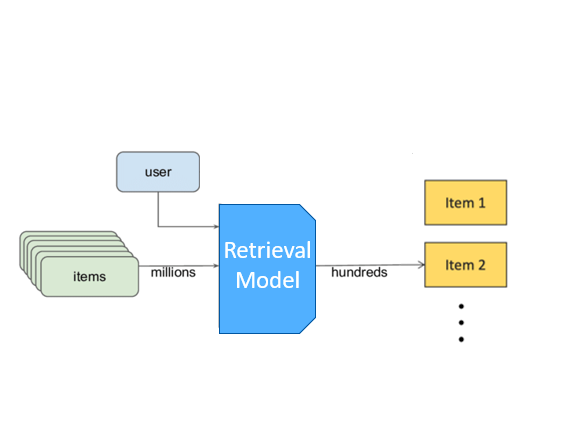

In [ ]:
# Create a model that takes in raw query features, and
index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)
# recommends movies out of the entire movies dataset.
index.index_from_dataset(
    tf.data.Dataset.zip(
        (movies_candidates_pipeline, movies_candidates_pipeline.map(model.movie_model))
    )
)

# Get recommendations.
_, titles = index(tf.constant([42]))
print("Recommendations:")
for id in titles.numpy()[0]:

    print(id_movie[id])

Recommendations:
b'Time to Kill, A (1996)'
b'Daylight (1996)'
b'Michael Collins (1996)'
b'Phenomenon (1996)'
b'Boot, Das (1981)'
b'Twister (1996)'
b'Jerry Maguire (1996)'
b'Ghost and the Darkness, The (1996)'
b'White Squall (1996)'
b'Dead Man Walking (1995)'
